# Predicting Temperatures using Recurrent Neural Networks

This notebook provides you with a complete code example that uses different kinds of recurrent neural networks to predict the temperature in the Jena Climate Dataset.

## Downloading the Jena Climate Dataset

This dataset contains timeseries recorded at the weather station of the Max Planck Institute for Biogeochemistry in Jena, Germany. It’s made up of 14 different quantities recorded every 10 minutes over several years, from January 1st 2009 to December 31st 2016.

Load the Jena Climante Dataset ...

In [65]:
import pandas as pd

dataframe = pd.read_csv("jena_climate_2009_2016.csv", index_col=0)
data = dataframe.values
header = dataframe.columns.tolist()

... and display its header and first few elements.

In [66]:
print(dataframe.head())

                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
01.01.2009 00:10:00          3.33          3.11          0.22       1.94   
01.01.2009 00:20:00          3.23          3.02          0.21       1.89   
01.01.2009 00:30:00          3.21          3.01          0.20       1.88   
01.01.2009 00:40:00          3.26          3.07          0.19       1.92   
01.01.2009 00:50:00      

### Visualizing the Data

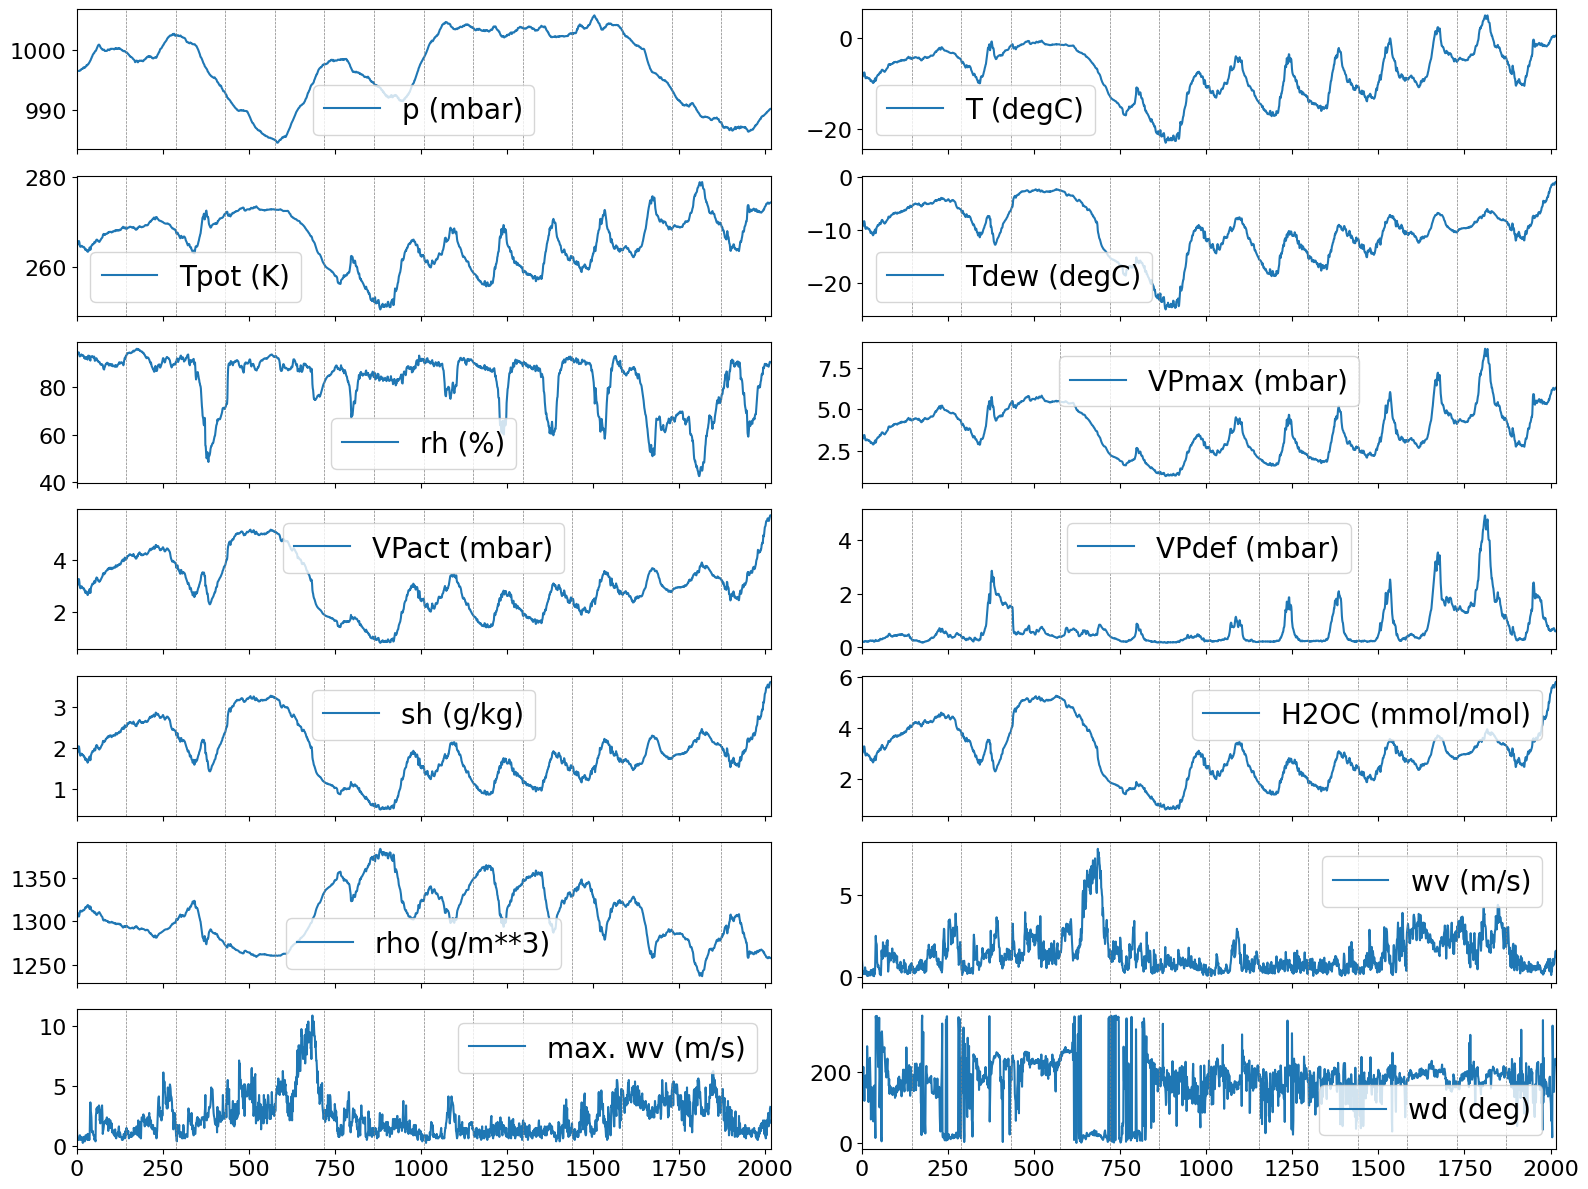

In [67]:
import matplotlib.pyplot as plt
import numpy as np

start, days, daily_samples = 0, 14, 144
end = start + daily_samples * days

fig, axes = plt.subplots(7, 2, figsize=(16, 12), sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.plot(np.arange(start, end), data[start:end, i], label=header[i])
    ax.set_xlim(start, end)
    ax.tick_params(axis="both", which="major", labelsize=16)
    ax.legend(fontsize=20)
    
    for day in range(1, days):
        ax.axvline(x=start + daily_samples * day,
                   color="gray", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()

### Preprocessing the Data

Reshape the data in a format ready to train a recurrent neural network ...

In [68]:
n_samples, n_features = data.shape[0], data.shape[1]
past_seq = 2 * daily_samples
lag = 72
temp_idx = 1  # Temperature (Celsius) index.

in_sequences, targets = [], []
for i in np.random.permutation(range(0, n_samples - past_seq - lag, 
                                     daily_samples)):
    in_sequences.append(data[i:i + past_seq, :])
    targets.append(data[i + past_seq + lag:i + past_seq + lag + 1, temp_idx])
in_sequences, targets = np.asarray(in_sequences), np.asarray(targets)

... check the input shape ...

In [69]:
print(in_sequences.shape)

(2918, 288, 14)


... check the output shape ...

In [70]:
print(targets.shape)

(2918, 1)


... splitting the data ...

In [71]:
import deeptrack as dt

sources = dt.sources.Source(inputs=in_sequences, targets=targets)
train_sources, val_sources = dt.sources.random_split(sources, [0.8, 0.2])

... standardize the data ...

In [72]:
import torch

train_mean = np.mean([src["inputs"] for src in train_sources], axis=(0, 1))
train_std = np.std([src["inputs"] for src in train_sources], axis=(0, 1))

inputs_pipeline = (dt.Value(sources.inputs - train_mean) / train_std 
                   >> dt.pytorch.ToTensor(dtype=torch.float))
targets_pipeline = (dt.Value(sources.targets - train_mean[temp_idx]) 
                    / train_std[temp_idx])

... and define the data loaders.

In [73]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(inputs_pipeline & targets_pipeline, 
                                   inputs=train_sources)
val_dataset = dt.pytorch.Dataset(inputs_pipeline & targets_pipeline, 
                                 inputs=val_sources)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Implementing a Common-Sense Benchmark

In [74]:
temperature = data[:, temp_idx]
benchmark_celsius = np.mean(
    np.abs(
        temperature[daily_samples + lag :: daily_samples] 
        - temperature[lag : -(daily_samples - lag) : daily_samples]
    )
)
benchmark = benchmark_celsius / train_std[temp_idx]

print(f"Benchmark Celsius: {benchmark_celsius}")
print(f"Normalized Benchmark: {benchmark}")

Benchmark Celsius: 2.664549503254539
Normalized Benchmark: 0.3157322766423574


## Determining on Which Device to Perform the Computations

In [75]:
def get_device():
    """Select device where to perform computations."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [76]:
device = get_device()

In [77]:
print(device)

mps


## Implementing a Simple Recurrent Neural Network

Define a recurrent neural network in PyTorch ...

In [83]:
import torch.nn as nn

rnn = nn.RNN(input_size=in_sequences.shape[2], hidden_size=2, batch_first=True)
fc = nn.Linear(in_features=2, out_features=1)
rnn.to(device); fc.to(device);

... train and validate it ...

In [84]:
criterion = nn.L1Loss()  # MAE Loss.
parameter_list = list(rnn.parameters()) + list(fc.parameters())
optimizer = torch.optim.Adam(parameter_list, lr=0.001)

epochs = 100

train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss = 0.0
    for in_sequences, targets in train_loader:
        optimizer.zero_grad()

        in_sequences, targets = in_sequences.to(device), targets.to(device)
        hidden_sequences, _ = rnn(in_sequences)  # RNN layer.
        last_hidden_states = hidden_sequences[:, -1, :]  # Last hidden states.

        predictions = fc(last_hidden_states)  # Linear layer.
        
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))
    print(f"Epoch {epoch} Training Loss: {train_losses[-1]:.4f}")
    
    val_loss = 0.0
    with torch.no_grad():
        for in_sequences, targets in val_loader:
            in_sequences, targets = in_sequences.to(device), targets.to(device)
            rnn_outputs, _ = rnn(in_sequences)
            rnn_outputs = rnn_outputs[:, -1, :]
            predictions = fc(rnn_outputs)
            
            loss = criterion(predictions, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch} Validation Loss: {val_losses[-1]:.4f}")

Epoch 0 Training Loss: 0.8605
Epoch 0 Validation Loss: 0.8065
Epoch 1 Training Loss: 0.8100
Epoch 1 Validation Loss: 0.7392
Epoch 2 Training Loss: 0.7181
Epoch 2 Validation Loss: 0.6211
Epoch 3 Training Loss: 0.6068
Epoch 3 Validation Loss: 0.5327
Epoch 4 Training Loss: 0.5365
Epoch 4 Validation Loss: 0.4892
Epoch 5 Training Loss: 0.5000
Epoch 5 Validation Loss: 0.4659
Epoch 6 Training Loss: 0.4787
Epoch 6 Validation Loss: 0.4513
Epoch 7 Training Loss: 0.4640
Epoch 7 Validation Loss: 0.4384
Epoch 8 Training Loss: 0.4516
Epoch 8 Validation Loss: 0.4280
Epoch 9 Training Loss: 0.4401
Epoch 9 Validation Loss: 0.4185
Epoch 10 Training Loss: 0.4305
Epoch 10 Validation Loss: 0.4115
Epoch 11 Training Loss: 0.4225
Epoch 11 Validation Loss: 0.4061
Epoch 12 Training Loss: 0.4163
Epoch 12 Validation Loss: 0.4013
Epoch 13 Training Loss: 0.4110
Epoch 13 Validation Loss: 0.3973
Epoch 14 Training Loss: 0.4070
Epoch 14 Validation Loss: 0.3935
Epoch 15 Training Loss: 0.4032
Epoch 15 Validation Loss: 0.3

... and plot the training and validation losses.

In [30]:
def plot_training(epochs, train_losses, val_losses, benchmark):
    """Plot the training and validation losses."""
    plt.plot(range(epochs), train_losses, label="Training Loss")
    plt.plot(range(epochs), val_losses, "--", label="Validation Loss")
    plt.plot([0, epochs - 1], [benchmark, benchmark], ":k", label="Benchmark")
    plt.xlabel("Epoch"), plt.xlim([0, epochs - 1])
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
plot_training(epochs, train_losses, val_losses, benchmark)

## Implementing the Recurrent Neural Network in a More Compact Form with Deeplay

Define a recurrent neural network in deeplay ...

In [60]:
import deeplay as dl

rnn_dl = dl.RecurrentModel(
    in_features=n_features, 
    hidden_features=[2],
    out_features=1,
    rnn_type="RNN",
)
rnn_simple = dl.Regressor(rnn_dl, optimizer=dl.Adam(lr=0.001)).create()

... and train it.

In [ ]:
trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(rnn_simple, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)

## Stacking Multiple Recurrent Layers

In [ ]:
import deeplay as dl

rnn_dl = dl.RecurrentModel(
    in_features=n_features, 
    hidden_features=[16, 16, 16],
    out_features=1,
    rnn_type="RNN",
)
rnn_stacked = dl.Regressor(rnn_dl, optimizer=dl.Adam(lr=0.0001)).create()

trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(rnn_stacked, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)

## Using Gated Recurrent Units

In [ ]:
import deeplay as dl

gru_dl = dl.RecurrentModel(
    in_features=n_features, 
    hidden_features=[8, 8, 8],
    out_features=1,
    rnn_type="GRU",
    dropout=0.2,
)
gru_stacked = dl.Regressor(gru_dl, optimizer=dl.Adam(lr=0.001)).create()

trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(gru_stacked, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)

## Using Long Short-Term Memory Networks

In [ ]:
import deeplay as dl

lstm_dl = dl.RecurrentModel(
    in_features=n_features, 
    hidden_features=[8, 8, 8],
    out_features=1,
    rnn_type="LSTM",
    dropout=0.4,
)
lstm_stacked = dl.Regressor(lstm_dl, optimizer=dl.Adam(lr=0.001)).create()

trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(lstm_stacked, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)